# Part 2: Evaluation with Trainable Basis Functions

[Step 1: import related libraries](#Step-1:-import-related-libraries)\
[Step 2: setting up configuration](#Step-2:-setting-up-configuration)\
[Step 3: setting up nnAudio basis functions](#Step-3:-setting-up-nnAudio-basis-functions)\
[Step 4: setting up dataset](#Step-4:-setting-up-dataset)\
[Step 5: data processing and loading](#Step-5:-data-processing-and-loading)\
[Step 6: setting up the ligthning module](#Step-6:-setting-up-the-ligthning-module)\
[Step 7: setting up model and applying the ligthning module](#Step-7:-setting-up-model-and-applying-the-ligthning-module)\
[Step 8: loading pre-trained weight to model](#Step-8:-loading-pre-trained-weight-to-model)\
[Step 9: evaluating the model performance](#Step-9:-evaluating-the-model-performance)

[Visualizing result](#Visualizing-result)



## Step 1: import related libraries

In [1]:
# Libraries related to PyTorch
import torch
from torch import Tensor 
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Libraries related to PyTorch Lightning
from pytorch_lightning import Trainer
from pytorch_lightning.core.lightning import LightningModule

# Libraries used for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import re
import itertools

#Libraried related to dataset
from AudioLoader.Speech import SPEECHCOMMANDS_12C #for 12 classes KWS task
from AudioLoader.Speech import idx2name, name2idx
from collections import OrderedDict

# nnAudio Front-end
from nnAudio.features.mel import MelSpectrogram, STFT


## Step 2: setting up configuration

In [2]:
device = 'cuda:0'
gpus = 1
batch_size= 100
max_epochs = 200
check_val_every_n_epoch = 2
num_sanity_val_steps = 5

data_root= './' # Download the data here
download_option= False

n_mels= 40 
#number of Mel bases

input_dim= (n_mels*101)
output_dim= 12

random_mel= False   
#To control random initial mel bases  

# nnAudio guideline for trainable basis functions 
```
nnAudio.features.mel.MelSpectrogram(trainable_mel= ,trainable_STFT=) 
```
The function above is controlling if mel bases and STFT trainable

* A. Both Mel and STFT are non-trainable: 
`trainable_mel=False, trainable_STFT=False`
* B. Mel is trainable while STFT is fixed: 
`trainable_mel=True, trainable_STFT=False`
* C. gMel is fixed while gSTFT is trainable: 
`trainable_mel=False, trainable_STFT=True`
* D. Both gMel and gSTFT are trainable:
`trainable_mel=True, trainable_STFT=True`

## Step 3: setting up nnAudio basis functions

In [3]:
mel_layer = MelSpectrogram(sr=16000, 
                           n_fft=480,
                           win_length=None,
                           n_mels=n_mels, 
                           hop_length=160,
                           window='hann',
                           center=True,
                           pad_mode='reflect',
                           power=2.0,
                           htk=False,
                           fmin=0.0,
                           fmax=None,
                           norm=1,
                           trainable_mel=True,
                           trainable_STFT=True,
                           verbose=True)

STFT kernels created, time used = 0.0161 seconds
STFT filter created, time used = 0.0022 seconds
Mel filter created, time used = 0.0022 seconds


## Step 4: setting up dataset

In [4]:
testset = SPEECHCOMMANDS_12C(root=data_root,
                              url='speech_commands_v0.02',
                              folder_in_archive='SpeechCommands',
                              download= download_option,subset= 'testing')

basename='speech_commands_test_set_v0.02.tar.gz'


Loading testing set: 100%|████████████████████████████████████████████████████████| 4890/4890 [00:01<00:00, 2800.03it/s]


## Step 5: data processing and loading

In [5]:
#Data processing
def data_processing(data):
    waveforms = []
    labels = []
    
    for batch in data:
        waveforms.append(batch[0].squeeze(0)) #after squeeze => (audio_len) tensor # remove batch dim
        labels.append(batch[2])      
        
    waveform_padded = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)  
    
    output_batch = {'waveforms': waveform_padded, 
             'labels': torch.tensor(labels),
             }
    return output_batch

# load data
testloader = DataLoader(testset,   
                              collate_fn=lambda x: data_processing(x),
                                        batch_size=batch_size)    

## Step 6: setting up the ligthning module

In [50]:
class SpeechCommand(LightningModule):     
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx,
                       optimizer_closure, on_tpu, using_native_amp, using_lbfgs):
        
        optimizer.step(closure=optimizer_closure)
        with torch.no_grad():
            torch.clamp_(self.mel_layer.mel_basis, 0, 1)
        #after optimizer step, do clamp function on mel_basis (only applicable for nnAudio)
        #FastAudio internal has clamp function
        
    def test_step(self, batch, batch_idx):               
        outputs, spec = self(batch['waveforms'])
        loss = self.criterion(outputs, batch['labels'].long())        

        self.log('Test/Loss', loss, on_step=False, on_epoch=True)          
        
        output_dict = {'outputs': outputs,
                       'labels': batch['labels']}        
        return output_dict
    
#     def test_epoch_end(self, outputs):
#         pred = []
#         label = []
#         for output in outputs:
#             pred.append(output['outputs'])
#             label.append(output['labels'])
#         label = torch.cat(label, 0)
#         pred = torch.cat(pred, 0)
        
#         result_dict = {}
#         for key in [None, 'micro', 'macro', 'weighted']:
#             result_dict[key] = {}
#             p, r, f1, _ = precision_recall_fscore_support(label.cpu(), pred.argmax(-1).cpu(), average=key, zero_division=0)
#             result_dict[key]['precision'] = p
#             result_dict[key]['recall'] = r
#             result_dict[key]['f1'] = f1
            
# #         barplot(result_dict, 'precision')
# #         barplot(result_dict, 'recall')
# #         barplot(result_dict, 'f1')
            
#         acc = sum(pred.argmax(-1) == label)/label.shape[0]
#         self.log('Test/acc', acc, on_step=False, on_epoch=True)
        
#         self.log('Test/micro_f1', result_dict['micro']['f1'], on_step=False, on_epoch=True)
#         self.log('Test/macro_f1', result_dict['macro']['f1'], on_step=False, on_epoch=True)
#         self.log('Test/weighted_f1', result_dict['weighted']['f1'], on_step=False, on_epoch=True)
          
        
#         return result_dict

    def test_epoch_end(self, outputs):
        pred = []
        label = []
        for output in outputs:
            pred.append(output['outputs'])
            label.append(output['labels'])
        label = torch.cat(label, 0)
        pred = torch.cat(pred, 0)
        
        result_dict = {}
        for key in [None, 'micro', 'macro', 'weighted']:
            result_dict[key] = {}
            p, r, f1, _ = precision_recall_fscore_support(label.cpu(), pred.argmax(-1).cpu(), average=key, zero_division=0)
            result_dict[key]['precision'] = p
            result_dict[key]['recall'] = r
            result_dict[key]['f1'] = f1
            
#         fig, (ax1,ax2,ax3) =plt.subplots(1,3)
#         ax1.bar(result_dict, 'precision')
#         ax1.set_title('precision')
#         ax2.bar(result_dict, 'recall')
#         ax2.set_title('recall')
#         ax3.bar(result_dict, 'f1')
#         ax3.set_title('f1')
        barplot(result_dict, 'precision', figsize=(4,6))
        barplot(result_dict, 'recall',figsize=(4,6))
        barplot(result_dict, 'f1',figsize=(4,6))
            
        acc = sum(pred.argmax(-1) == label)/label.shape[0]
        self.log('Test/acc', acc, on_step=False, on_epoch=True)
        
        self.log('Test/micro_f1', result_dict['micro']['f1'], on_step=False, on_epoch=True)
        self.log('Test/macro_f1', result_dict['macro']['f1'], on_step=False, on_epoch=True)
        self.log('Test/weighted_f1', result_dict['weighted']['f1'], on_step=False, on_epoch=True)
        
        cm = plot_confusion_matrix(label.cpu(),
                                   pred.argmax(-1).cpu(),
                                   name2idx.keys(),
                                   title='Test: Confusion matrix',
                                   normalize=False)
#         self.logger.experiment.add_figure('Test/confusion_maxtrix', cm, global_step=self.current_epoch)        
        
               
        return result_dict

def plot_confusion_matrix(correct_labels,
                          predict_labels,
                          labels,
                          title='Confusion matrix',
                          normalize=False):
    ''' 
    Parameters:
        correct_labels                  : These are your true classification categories.
        predict_labels                  : These are you predicted classification categories
        labels                          : This is a lit of labels which will be used to display the axix labels
        title='Confusion matrix'        : Title for your matrix
        tensor_name = 'MyFigure/image'  : Name for the output summay tensor
    Returns:
        summary: TensorFlow summary 
    Other itema to note:
        - Depending on the number of category and the data , you may have to modify the figzie, font sizes etc. 
        - Currently, some of the ticks dont line up due to rotations.
    '''
    cm = confusion_matrix(correct_labels, predict_labels, labels=range(len(labels)))
    if normalize:
        cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm, copy=True)
        cm = cm.astype('int')

    np.set_printoptions(precision=2)

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=160, facecolor='w', edgecolor='k')
    fig.suptitle('confusion_matrix',fontsize=7)
    im = ax.imshow(cm, cmap='Oranges')

    classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in labels]
    #classes = ['\n'.join(l) for l in classes]

    tick_marks = np.arange(len(classes))

    ax.set_xlabel('Predicted', fontsize=7)
    ax.set_xticks(tick_marks)
    c = ax.set_xticklabels(classes, fontsize=5, rotation=0,  ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True Label', fontsize=7)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=5, va ='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
    fig.set_tight_layout(True)

    return fig

def barplot(result_dict, title, figsize=(4,12), minor_interval=0.2, log=False):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    metric = {}
    for idx, item in enumerate(result_dict[None][title]):
        metric[idx2name[idx]] = item
    xlabels = list(metric.keys())
    values = list(metric.values())
    if log:
        values = np.log(values)
    ax.barh(xlabels, values)
    ax.tick_params(labeltop=True, labelright=False)
    ax.xaxis.grid(True, which='minor')
    ax.xaxis.set_minor_locator(MultipleLocator(minor_interval))
    ax.set_ylim([-1,len(xlabels)])
    ax.set_title(title)
    ax.grid(axis='x')
    ax.grid(b=True, which='minor', linestyle='--')
    fig.savefig(f'{title}.png', bbox_inches='tight')
    fig.tight_layout() # prevent edge from missing
    return fig

## Step 7: setting up model and applying the ligthning module

In [51]:
class Linearmodel_nnAudio(SpeechCommand):
    def __init__(self): 
        super().__init__()
        self.mel_layer = mel_layer       
        self.criterion = nn.CrossEntropyLoss()
        self.linearlayer = nn.Linear(input_dim, output_dim)
        #cfg.model.args.input_dim will be calculated in training script 
   
        if random_mel == True:
            nn.init.kaiming_uniform_(self.mel_layer.mel_basis, mode='fan_in')
            self.mel_layer.mel_basis.requires_grad = False
            torch.relu_(self.mel_layer.mel_basis)
            self.mel_layer.mel_basis.requires_grad = True
            #for randomly initialize mel bases
    
    def forward(self, x): 
        #x: 2D [B, 16000]
        spec = self.mel_layer(x)  
        #spec: 3D [B, F40, T101]
        
        spec = torch.log(spec+1e-10)
        
        flatten_spec = torch.flatten(spec, start_dim=1) 
        #flatten_spec: 2D [B, F*T(40*101)] 
        #start_dim: flattening start from 1st dimention
        
        out = self.linearlayer(flatten_spec) 
        #out: 2D [B,number of class(12)] 
                               
        return out, spec 

# nnAudio is integrated into the model at line 50 of models/nnAudio_model.py 
net = Linearmodel_nnAudio()
net = net.to(device)

## Step 8: loading pre-trained weight to model
Everytime you train a model after part 1 tutorial, the trained weight will be saved in `lightning_logs` folder

In [52]:
trained_weight= net.load_from_checkpoint('trained_weight_for_tutorial2/SGD-n_mels=40-Linearmodel_nnAudio-mel=True-STFT=False-speechcommand/version_1/checkpoints/last.ckpt')
# Test/acc': 0.39 mel train

In [53]:
# trained_weight=net.load_from_checkpoint('lightning_logs/version_47/checkpoints/epoch=199-step=171199.ckpt')
# Test/acc': 0.42 both train

## Step 9: evaluating the model performance 
Model performance can be demostrated in the following way:
* Test/Loss
* Test/acc
* F1 matrix 
* Confusion_matrix

**Way to confirm model is trained/weight loaded correctly:**

* For Linearmodel in keyword spotting (KWS) task, accuracy for Mel trainable with fixed STFT should be around 40%

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/root/anaconda3/envs/python3.8.10/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/tmp/ipykernel_4741/2530640846.py:166: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--')
/tmp/ipykernel_4741/2530640846.py:166: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--')
/tmp/ipykernel_4741/2530640846.py:166: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--')


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Loss': 11.118704795837402,
 'Test/acc': 0.39325153827667236,
 'Test/macro_f1': 0.39241334795951843,
 'Test/micro_f1': 0.39325153827667236,
 'Test/weighted_f1': 0.39341074228286743}
--------------------------------------------------------------------------------


[{'Test/Loss': 11.118704795837402,
  'Test/acc': 0.39325153827667236,
  'Test/micro_f1': 0.39325153827667236,
  'Test/macro_f1': 0.39241334795951843,
  'Test/weighted_f1': 0.39341074228286743}]

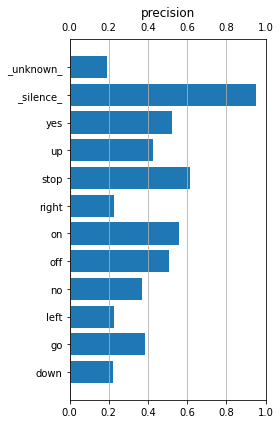

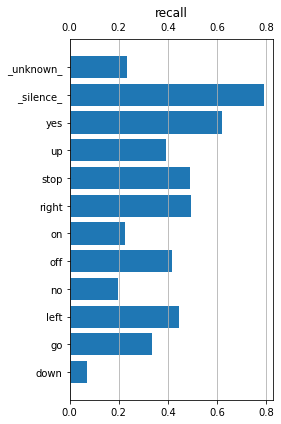

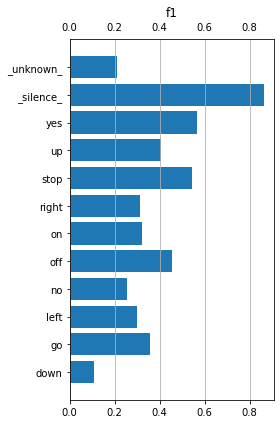

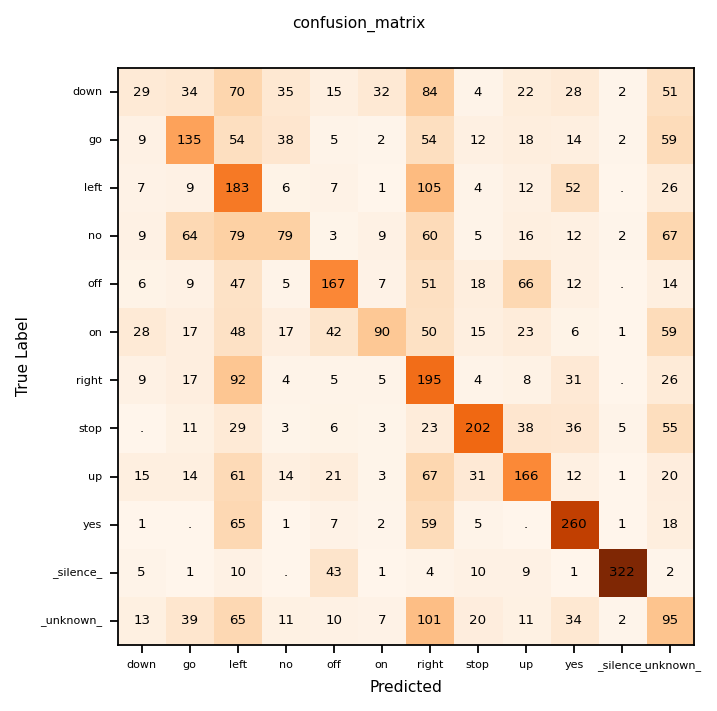

In [54]:
trainer = Trainer(gpus=gpus, max_epochs=max_epochs,
    check_val_every_n_epoch= check_val_every_n_epoch,
    num_sanity_val_steps=num_sanity_val_steps)

trainer.test(trained_weight, testloader)
#added validloader, in order to reach validation_step

# Visualizing result 
We can visualize the effect of trainable basis functions in the following way:
1. [Visualizing Mel bases](#Visualizing-Mel-bases)
1. [Visualizing short-time Fourier transform (STFT)](#Visualizing-STFT)

Before we start visualizing the result, let's explore the structure inside the checkpoint file.
```
weight=torch.load('xxxx/checkpoints/xxxx.ckpt')
├── epoch
├── global_step
├── pytorch-lightning_version
│     
├── state_dict
│     ├─ mel_layer.mel_basis
│     ├─ mel_layer.stft.wsin
│     ├─ mel_layer.stft.wcos
│     ├─ mel_layer.stft.window_mask   
│     ├─ linearlayer.weight
│     ├─ linearlayer.bias
│     │
│     
├── callbacks
├── optimizer_states
├── lr_schedulers
```
`torch.load('xxxx/checkpoints/xxxx.ckpt')` is a dictionary, its keys can be checked in the following:

In [57]:
weight=torch.load('trained_weight_for_tutorial2/SGD-n_mels=40-Linearmodel_nnAudio-mel=True-STFT=False-speechcommand/version_1/checkpoints/last.ckpt',map_location='cuda:0')

In [88]:
# weight=torch.load('lightning_logs/version_47/checkpoints/epoch=199-step=171199.ckpt')

In [58]:
weight.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers'])

`'state_dict'` is one of the key in the checkpoint file, it is an `OrderedDict` which including the **trained weight for basis functions (Mel bases, STFT) and layer weight (linear layer in this case)**.\
Keys for the 'state_dict' (OrderedDict) can be checked in the following:



In [59]:
weight['state_dict'].keys()

odict_keys(['mel_layer.mel_basis', 'mel_layer.stft.wsin', 'mel_layer.stft.wcos', 'mel_layer.stft.window_mask', 'linearlayer.weight', 'linearlayer.bias'])

## Visualizing Mel bases
Shape of `'mel_layer.mel_basis'` should be `[n_mels, (n_fft/2+1)]`\
In the case of `linear model in keyword spotting task`, shape of 'mel_layer.mel_basis' is `[40, 241]`

In [60]:
mel_filter_banks = weight['state_dict']['mel_layer.mel_basis']

**Individual Mel bases can be shown in the following:**
```python
plt.plot(mel_filter_banks[i].cpu().detach().numpy())
```
Simply replace `i` with `the numebr of Mel base`

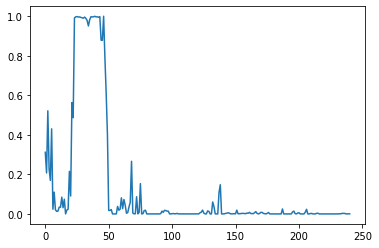

In [62]:
plt.plot(mel_filter_banks[0].cpu().detach().numpy())
plt.show()

**40 Mel bases can be shown in the following:**

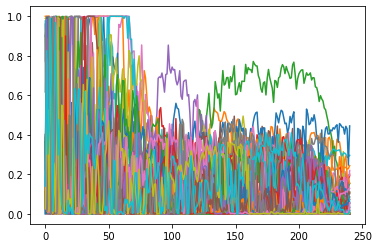

In [61]:
for i in mel_filter_banks:
    plt.plot(i.cpu().detach().numpy())  

## Visualizing STFT
Shape of `'mel_layer.stft.wsin'` and `'mel_layer.stft.wcos'` should be `[(n_fft/2+1),1,n_fft]`\
In the case of `linear model in keyword spotting task`, their shape should be  `[241, 1, 480]`

In [108]:
wsin = weight['state_dict']['mel_layer.stft.wsin']
wcos = weight['state_dict']['mel_layer.stft.wcos']

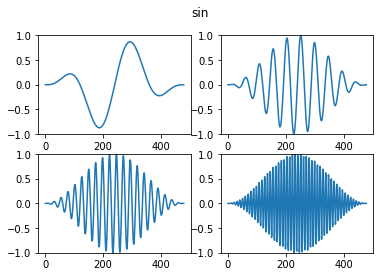

In [109]:
fig, axes = plt.subplots(2,2)
for ax, kernel_num in zip(axes.flatten(), [2,10,20,50]):
    ax.plot(wsin[kernel_num,0].cpu())
    ax.set_ylim(-1,1)
    fig.suptitle('sin')

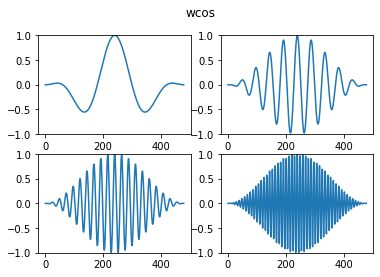

In [110]:
fig, axes = plt.subplots(2,2)
for ax, kernel_num in zip(axes.flatten(), [2,10,20,50]):
    ax.plot(wcos[kernel_num,0].cpu())
    ax.set_ylim(-1,1)
    fig.suptitle('wcos')

In [112]:
window_mask = weight['state_dict']['mel_layer.stft.window_mask']
#[1, 480, 1]

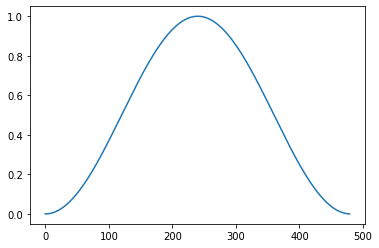

In [113]:
for i in window_mask:
    plt.plot(i.cpu().detach().numpy())  